In [4]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from tqdm import tqdm


In [5]:
import visdom
import numpy as np
import torch

class Visualizer(object):
    def __init__(self, env='default', **kwargs):
        self.vis = visdom.Visdom(env=env, **kwargs)
        self.index = {}

    def plot_lines(self, name, y, **kwargs):
        '''
        self.plot('loss', 1.00)
        '''
        x = self.index.get(name, 0)
        self.vis.line(Y=np.array([y]), X=np.array([x]),
                      win=str(name),
                      opts=dict(title=name),
                      update=None if x == 0 else 'append',
                      **kwargs
                      )
        self.index[name] = x + 1
    def disp_image(self, name, img):
        self.vis.image(img=img, win=name, opts=dict(title=name))
    def lines(self, name, line, X=None):
        if X is None:
            self.vis.line(Y=line, win=name)
        else:
            self.vis.line(X=X, Y=line, win=name)
    def scatter(self, name, data):
        self.vis.scatter(X=data, win=name)

def process_feat(feat, length):
    new_feat = np.zeros((length, feat.shape[1])).astype(np.float32)
    
    r = np.linspace(0, len(feat), length+1, dtype=int)
    for i in range(length):
        if r[i]!=r[i+1]:
            new_feat[i,:] = np.mean(feat[r[i]:r[i+1],:], 0)
        else:
            new_feat[i,:] = feat[r[i],:]
    return new_feat


def minmax_norm(act_map, min_val=None, max_val=None):
    if min_val is None or max_val is None:
        relu = torch.nn.ReLU()
        max_val = relu(torch.max(act_map, dim=0)[0])
        min_val = relu(torch.min(act_map, dim=0)[0])

    delta = max_val - min_val
    delta[delta <= 0] = 1
    ret = (act_map - min_val) / delta

    ret[ret > 1] = 1
    ret[ret < 0] = 0

    return ret


def modelsize(model, input, type_size=4):
    # check GPU utilisation
    para = sum([np.prod(list(p.size())) for p in model.parameters()])
    print('Model {} : params: {:4f}M'.format(model._get_name(), para * type_size / 1000 / 1000))

    input_ = input.clone()
    input_.requires_grad_(requires_grad=False)

    mods = list(model.modules())
    out_sizes = []

    for i in range(1, len(mods)):
        m = mods[i]
        if isinstance(m, nn.ReLU):
            if m.inplace:
                continue
        out = m(input_)
        out_sizes.append(np.array(out.size()))
        input_ = out

    total_nums = 0
    for i in range(len(out_sizes)):
        s = out_sizes[i]
        nums = np.prod(np.array(s))
        total_nums += nums


    print('Model {} : intermedite variables: {:3f} M (without backward)'
          .format(model._get_name(), total_nums * type_size / 1000 / 1000))
    print('Model {} : intermedite variables: {:3f} M (with backward)'
          .format(model._get_name(), total_nums * type_size*2 / 1000 / 1000))


def save_best_record(test_info, file_path):
    fo = open(file_path, "w")
    fo.write("epoch: {}\n".format(test_info["epoch"][-1]))
    fo.write(str(test_info["test_AUC"][-1]))
    fo.close()

In [6]:

viz = Visualizer(env='myenv', use_incoming_socket=False)

Setting up a new session...
Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [7]:
feat_extractor='i3d'
feature_size=1024
modality='RGB'
gt=r'C:\Users\pradh\Downloads\XDVioDet-master\XDVioDet-master\list\gt.npy'
gpus=1
lr='[0.001]*15000'
batch_size=32
workers=4
model_name='rtfm'
pretrained_ckpt=None
num_classes=1
dataset='xdv'
plot_freq=10
max_epoch=250


In [8]:
import torch.utils.data as data
import numpy as np
import torch
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.FloatTensor')


class Dataset(data.Dataset):
    def __init__(self, is_normal, transform=None, test_mode=False):
        self.modality='RGB'
        self.is_normal = is_normal
        self.dataset = dataset
        if test_mode:
            self.rgb_list_file = r'C:\Users\pradh\Downloads\XDVioDet-master\XDVioDet-master\list\tratestlst.list'
        else:
            self.rgb_list_file = r'C:\Users\pradh\Downloads\XDVioDet-master\XDVioDet-master\list\tratrainlst.list'
        self.tranform = transform
        self.test_mode = test_mode
        self._parse_list()
        self.num_frame = 0
        self.labels = None
        


    def _parse_list(self):
        self.list = list(open(self.rgb_list_file))
        if self.test_mode is False:
            if self.is_normal:
                self.list = self.list[1987:]
                print('normal list for ucf')
                print(self.list)
            else:
                self.list = self.list[:1987]
                print('abnormal list for ucf')
                print(self.list)
        

    def __getitem__(self, index):

        label = self.get_label()  # get video level label 0/1
        features = np.load(self.list[index].strip('\n'), allow_pickle=True)
        features = np.array(features, dtype=np.float32)

        if self.tranform is not None:
            features = self.tranform(features)
        if self.test_mode:
            return features
        else:
            # process 10-cropped snippet feature
            features = features.transpose(1, 0, 2)  # [10, B, T, F]
            divided_features = []
            for feature in features:
                feature = process_feat(feature, 32)  # divide a video into 32 segments
                divided_features.append(feature)
            divided_features = np.array(divided_features, dtype=np.float32)

            return divided_features, label

    def get_label(self):

        if self.is_normal:
            label = torch.tensor(0.0)
        else:
            label = torch.tensor(1.0)

        return label

    def __len__(self):
        return len(self.list)
    
    def leng(self):
        return len(self.list)

    def get_num_frames(self):
        return self.num_frame

c:\Users\pradh\anaconda3\envs\myenv\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [9]:

train_nloader = DataLoader(Dataset( test_mode=False, is_normal=True),
                               batch_size=32, shuffle=True,
                               num_workers=0, pin_memory=False, drop_last=False)
train_aloader = DataLoader(Dataset( test_mode=False, is_normal=False),
                               batch_size=32, shuffle=True,
                              num_workers=0, pin_memory=False, drop_last=False)
test_loader = DataLoader(Dataset( test_mode=True,is_normal=True),
                              batch_size=1, shuffle=False,
                              num_workers=0, pin_memory=False)
print(len(train_nloader))
print(len(train_aloader))
print(len(test_loader))





normal list for ucf
['C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-29-31_01-31-00_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-33-18_01-36-11_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-39-05_01-41-00_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-50-50_01-52-00_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-52-20_01-58-00_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-58-20_02-01-10_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Before.Sunrise.1995__#00-01-45_00-02-50_label_A.npy\n', 'C:\\Users\\pradh\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Before.Sunris

In [10]:
import torch
import torch.nn as nn
import torch.nn.init as torch_init
torch.set_default_dtype(torch.float32)

def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        torch_init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x, return_nl_map=False):
        """
        :param x: (b, c, t, h, w)
        :param return_nl_map: if True return z, nl_map, else only return z.
        :return:
        """

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)

        f = torch.matmul(theta_x, phi_x)
        N = f.size(-1)
        f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        if return_nl_map:
            return z, f_div_C
        return z


class NONLocalBlock1D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock1D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=1, sub_sample=sub_sample,
                                              bn_layer=bn_layer)



class Aggregate(nn.Module):
    def __init__(self, len_feature):
        super(Aggregate, self).__init__()
        bn = nn.BatchNorm1d
        self.len_feature = len_feature
        self.conv_1 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1,dilation=1, padding=1),
            nn.ReLU(),
            bn(512)
            #nn.dropout(0.7)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1, dilation=2, padding=2),
            nn.ReLU(),
            bn(512)
            #nn.dropout(0.7)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1, dilation=4, padding=4),
            nn.ReLU(),
            bn(512)
            #nn.dropout(0.7),
        )
        self.conv_4 = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=1,
                      stride=1, padding=0, bias = False),
            nn.ReLU(),
            #nn.dropout(0.7),
        )
        self.conv_5 = nn.Sequential(
            nn.Conv1d(in_channels=2048, out_channels=1024, kernel_size=3,
                      stride=1, padding=1, bias=False), # should we keep the bias?
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            #nn.dropout(0.7)
        )

        self.non_local = NONLocalBlock1D(512, sub_sample=False, bn_layer=True)


    def forward(self, x):
            # x: (B, T, F)
            out = x.permute(0, 2, 1)
            residual = out

            out1 = self.conv_1(out)
            out2 = self.conv_2(out)

            out3 = self.conv_3(out)
            out_d = torch.cat((out1, out2, out3), dim = 1)
            out = self.conv_4(out)
            out = self.non_local(out)
            out = torch.cat((out_d, out), dim=1)
            out = self.conv_5(out)   # fuse all the features together
            out = out + residual
            out = out.permute(0, 2, 1)
            # out: (B, T, 1)

            return out

class Model(nn.Module):
    def __init__(self, n_features, batch_size):
        super(Model, self).__init__()
        self.batch_size = 32
        self.num_segments = 32
        self.k_abn = self.num_segments // 10
        self.k_nor = self.num_segments // 10

        self.Aggregate = Aggregate(len_feature=1024)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        self.drop_out = nn.Dropout(0.7)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.apply(weight_init)

    def forward(self, inputs):

        k_abn = self.k_abn
        k_nor = self.k_nor

        out = inputs
        bs, ncrops, t, f = out.size()

        out = out.view(-1, t, f)

        out = self.Aggregate(out)

        out = self.drop_out(out)


        features = out
        scores = self.relu(self.fc1(features))
        scores = self.drop_out(scores)
        scores = self.relu(self.fc2(scores))
        scores = self.drop_out(scores)
        scores = self.sigmoid(self.fc3(scores))
        scores = scores.view(bs, ncrops, -1).mean(1)
        scores = scores.unsqueeze(dim=2)
        

        normal_features = features[0:self.batch_size*5]
        normal_scores = scores[0:self.batch_size]
      
        abnormal_features = features[self.batch_size*5:]
        abnormal_scores = scores[self.batch_size:]
        

        feat_magnitudes = torch.norm(features, p=2, dim=2)
        feat_magnitudes = feat_magnitudes.view(bs, ncrops, -1).mean(1)

        afea_magnitudes = feat_magnitudes[self.batch_size:]  # abnormal feature magnitudes
        #print(feat_magnitudes.shape[0])
        nfea_magnitudes = feat_magnitudes[0:self.batch_size]  # normal feature magnitudes
        #print(self.batch_size)
        n_size = nfea_magnitudes.shape[0]
        a_size = afea_magnitudes.shape[0]
        #print(afea_magnitudes.shape[0])
        #print(nfea_magnitudes.shape[0])
        
        #print(self.batch_size)

        if nfea_magnitudes.shape[0] == 1:  # this is for inference, the batch size is 1
            afea_magnitudes = nfea_magnitudes
            abnormal_scores = normal_scores
            abnormal_features = normal_features
            n_size = nfea_magnitudes.shape[0]
            a_size = nfea_magnitudes.shape[0]



        select_idx = torch.ones_like(afea_magnitudes)
        select_idx = self.drop_out(select_idx)

        #######  process abnormal videos -> select top3 feature magnitude  #######
        afea_magnitudes_drop = afea_magnitudes * select_idx
        idx_abn = torch.topk(afea_magnitudes_drop, k_abn, dim=1)[1]
        idx_abn_feat = idx_abn.unsqueeze(2).expand([-1, -1, abnormal_features.shape[2]])

        abnormal_features = abnormal_features.view(a_size, ncrops, t, f)
        abnormal_features = abnormal_features.permute(1, 0, 2,3)

        total_select_abn_feature = torch.zeros(0, device=inputs.device)
        for abnormal_feature in abnormal_features:
            feat_select_abn = torch.gather(abnormal_feature, 1, idx_abn_feat)   # top 3 features magnitude in abnormal bag
            total_select_abn_feature = torch.cat((total_select_abn_feature, feat_select_abn))

        idx_abn_score = idx_abn.unsqueeze(2).expand([-1, -1, abnormal_scores.shape[2]])
        score_abnormal = torch.mean(torch.gather(abnormal_scores, 1, idx_abn_score), dim=1)  # top 3 scores in abnormal bag based on the top-3 magnitude


        ####### process normal videos -> select top3 feature magnitude #######
        n_size=nfea_magnitudes.shape[0]

        select_idx_normal = torch.ones_like(nfea_magnitudes)
        select_idx_normal = self.drop_out(select_idx_normal)
        nfea_magnitudes_drop = nfea_magnitudes * select_idx_normal
        idx_normal = torch.topk(nfea_magnitudes_drop, k_nor, dim=1)[1]
        idx_normal_feat = idx_normal.unsqueeze(2).expand([-1, -1, normal_features.shape[2]])

        normal_features = normal_features.view(n_size, ncrops, t, f)
        normal_features = normal_features.permute(1, 0, 2, 3)

        total_select_nor_feature = torch.zeros(0, device=inputs.device)
        for nor_fea in normal_features:
            feat_select_normal = torch.gather(nor_fea, 1, idx_normal_feat)  # top 3 features magnitude in normal bag (hard negative)
            total_select_nor_feature = torch.cat((total_select_nor_feature, feat_select_normal))

        idx_normal_score = idx_normal.unsqueeze(2).expand([-1, -1, normal_scores.shape[2]])
        score_normal = torch.mean(torch.gather(normal_scores, 1, idx_normal_score), dim=1) # top 3 scores in normal bag

        feat_select_abn = total_select_abn_feature
        feat_select_normal = total_select_nor_feature

        return score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_select_abn, feat_select_abn, scores, feat_select_abn, feat_select_abn, feat_magnitudes

In [11]:
model = Model(feature_size,batch_size)

In [12]:
import numpy as np
import os

class Config(object):
    def __init__(self):
        self.lr = eval(lr)
        self.lr_str = lr

    def __str__(self):
        attrs = vars(self)
        attr_lst = sorted(attrs.keys())
        return '\n'.join("- %s: %s" % (item, attrs[item]) for item in attr_lst if item != 'lr')
    
config=Config()

In [13]:
import os
for name, value in model.named_parameters():
    print(name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#if not os.path.exists('./ckpt'):
os.makedirs('./ckpt')

optimizer = optim.Adam(model.parameters(),lr=config.lr[0], weight_decay=0.005)

test_info = {"epoch": [], "test_AUC": []}
best_AUC = -1
output_path = r"C:\Users\pradh\Downloads\output"  

Aggregate.conv_1.0.weight
Aggregate.conv_1.0.bias
Aggregate.conv_1.2.weight
Aggregate.conv_1.2.bias
Aggregate.conv_2.0.weight
Aggregate.conv_2.0.bias
Aggregate.conv_2.2.weight
Aggregate.conv_2.2.bias
Aggregate.conv_3.0.weight
Aggregate.conv_3.0.bias
Aggregate.conv_3.2.weight
Aggregate.conv_3.2.bias
Aggregate.conv_4.0.weight
Aggregate.conv_5.0.weight
Aggregate.conv_5.2.weight
Aggregate.conv_5.2.bias
Aggregate.non_local.g.weight
Aggregate.non_local.g.bias
Aggregate.non_local.W.0.weight
Aggregate.non_local.W.0.bias
Aggregate.non_local.W.1.weight
Aggregate.non_local.W.1.bias
Aggregate.non_local.theta.weight
Aggregate.non_local.theta.bias
Aggregate.non_local.phi.weight
Aggregate.non_local.phi.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


In [14]:
import matplotlib.pyplot as plt
import torch
import sklearn.metrics 
import numpy as np

def test(dataloader, model, viz, device):
    with torch.no_grad():
        model.eval()
        pred = torch.zeros(0, device=device)

        for i, input in enumerate(dataloader):
            input = input.to(device)
            input = input.permute(0, 2, 1, 3)
            score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_abn_bottom, feat_select_normal_bottom, logits,scores_nor_bottom, scores_nor_abn_bag, feat_magnitudes = model(inputs=input)
            logits = torch.squeeze(logits, 1)
            logits = torch.mean(logits, 0)
            sig = logits
            pred = torch.cat((pred, sig))

        

       
        gt = np.load(r"C:\Users\pradh\Downloads\XDVioDet-master\XDVioDet-master\list\gt.npy")
        pred = list(pred.cpu().detach().numpy())
        # print(pred)
        # print(len(pred))
        pred = np.repeat(np.array(pred), 16)
        

        fpr, tpr, threshold = sklearn.metrics.roc_curve(list(gt), pred)
        fpr_values = list(fpr)
        tpr_values = list(tpr)

        fpr_array = np.array(fpr_values)
        tpr_array = np.array(tpr_values)
#         print(fpr1)
#         print(tpr1)
#         np.save('fpr.npy', fpr2)
#         np.save('tpr.npy', tpr2)
        rec_auc = sklearn.metrics.auc(fpr_array, tpr_array)
        #print('auc : ' + str(rec_auc))

        precision, recall, th = sklearn.metrics.precision_recall_curve(list(gt), pred)
        pr_auc = sklearn.metrics.auc(recall, precision)
        np.save('precision.npy', precision)
        np.save('recall.npy', recall)
        viz.plot_lines('pr_auc', pr_auc)
        viz.plot_lines('auc', rec_auc)
        viz.lines('scores', pred)
        viz.lines('roc', tpr_values, fpr_values)
        return rec_auc,fpr,tpr


In [15]:
auc,fpr,tpr=test(test_loader, model, viz, device)
print(auc)

0.5183031161317266


In [16]:
import numpy as np
import torch
import torch.nn.functional as F
torch.set_default_tensor_type('torch.FloatTensor')
from torch.nn import L1Loss
from torch.nn import MSELoss



def sparsity(arr, batch_size, lamda2):
    loss = torch.mean(torch.norm(arr, dim=0))
    return lamda2*loss


def smooth(arr, lamda1):
    arr2 = torch.zeros_like(arr)
    arr2[:-1] = arr[1:]
    arr2[-1] = arr[-1]

    loss = torch.sum((arr2-arr)**2)

    return lamda1*loss


def l1_penalty(var):
    return torch.mean(torch.norm(var, dim=0))


class SigmoidMAELoss(torch.nn.Module):
    def __init__(self):
        super(SigmoidMAELoss, self).__init__()
        from torch.nn import Sigmoid
        self.__sigmoid__ = Sigmoid()
        self.__l1_loss__ = MSELoss()

    def forward(self, pred, target):
        return self.__l1_loss__(pred, target)


class SigmoidCrossEntropyLoss(torch.nn.Module):
    # Implementation Reference: http://vast.uccs.edu/~adhamija/blog/Caffe%20Custom%20Layer.html
    def __init__(self):
        super(SigmoidCrossEntropyLoss, self).__init__()

    def forward(self, x, target):
        tmp = 1 + torch.exp(- torch.abs(x))
        return torch.abs(torch.mean(- x * target + torch.clamp(x, min=0) + torch.log(tmp)))


class RTFM_loss(torch.nn.Module):
    def __init__(self, alpha, margin):
        super(RTFM_loss, self).__init__()
        self.alpha = alpha
        self.margin = margin
        self.sigmoid = torch.nn.Sigmoid()
        self.mae_criterion = SigmoidMAELoss()
        self.criterion = torch.nn.BCELoss()

    def forward(self, score_normal, score_abnormal, nlabel, alabel, feat_n, feat_a):
        label = torch.cat((nlabel, alabel), 0)
        score_abnormal = score_abnormal
        score_normal = score_normal


        score = torch.cat((score_normal, score_abnormal), 0)
        score = score.squeeze()

        #label = label.cuda()

        loss_cls = self.criterion(score, label)  # BCE loss in the score space

        loss_abn = torch.abs(self.margin - torch.norm(torch.mean(feat_a, dim=1), p=2, dim=1))

        loss_nor = torch.norm(torch.mean(feat_n, dim=1), p=2, dim=1)

        lsh=loss_nor.shape[0]
        ash=loss_abn.shape[0]
        if(lsh>=ash):
            sh=ash
        else:
            sh=lsh


        loss_rtfm = torch.mean((loss_abn + loss_nor[0:sh]) ** 2)

        loss_total = loss_cls + self.alpha * loss_rtfm

        return loss_total


def train(nloader, aloader, model, batch_size, optimizer, viz, device):
    with torch.set_grad_enabled(True):
        #batch_size=3
        
        model.train()

        ninput, nlabel = next(nloader)
        ainput, alabel = next(aloader)
        abns=ainput.shape[0]
        ns=ninput.shape[0]

        input = torch.cat((ninput, ainput), 0).to(device)
        #print(input.shape[0])
        score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_abn_bottom, \
        feat_normal_bottom, scores, scores_nor_bottom, scores_nor_abn_bag, _ = model(input)  # b*32  x 1024
        #print(scores.shape[0])
        scores = scores.view((ns+abns)* 32  , -1)

        scores = scores.squeeze()
        abn_scores = scores[ns * 32:]

        nlabel = nlabel[0:ns]
        alabel = alabel[0:abns]

        loss_criterion = RTFM_loss(0.0001, 100)
        loss_sparse = sparsity(abn_scores, abns, 8e-3)
        loss_smooth = smooth(abn_scores, 8e-4)
        cost = loss_criterion(score_normal, score_abnormal, nlabel, alabel, feat_select_normal, feat_select_abn) + loss_smooth + loss_sparse

        viz.plot_lines('loss', cost.item())
        viz.plot_lines('smooth loss', loss_smooth.item())
        viz.plot_lines('sparsity loss', loss_sparse.item())
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()



  0%|          | 1/250 [02:16<9:24:29, 136.02s/it]

0.5701739475137438


  1%|          | 2/250 [04:33<9:25:31, 136.82s/it]

0.6860061278021052


  1%|          | 3/250 [06:49<9:21:17, 136.35s/it]

0.7059877781687489


  2%|▏         | 4/250 [09:11<9:28:52, 138.75s/it]

0.7029442390757367


  2%|▏         | 5/250 [11:28<9:23:32, 138.01s/it]

0.7302454290101255


  2%|▏         | 6/250 [13:43<9:17:21, 137.05s/it]

0.7243250038102109


  3%|▎         | 7/250 [16:01<9:15:40, 137.20s/it]

0.6666057920841566


  3%|▎         | 8/250 [18:18<9:14:04, 137.37s/it]

0.6482842032122625


  4%|▎         | 9/250 [20:35<9:11:18, 137.26s/it]

0.6470178861727671


  4%|▍         | 10/250 [22:54<9:10:37, 137.65s/it]

0.6421514873630232


  4%|▍         | 11/250 [25:18<9:16:35, 139.73s/it]

0.6590154458576987


  5%|▍         | 12/250 [27:37<9:13:00, 139.41s/it]

0.6873866788791949


  5%|▌         | 13/250 [29:53<9:06:40, 138.40s/it]

0.715367839141732


  6%|▌         | 14/250 [32:10<9:02:49, 138.00s/it]

0.7474519330709777


  6%|▌         | 15/250 [34:26<8:58:19, 137.45s/it]

0.7697586466582549


  6%|▋         | 16/250 [36:42<8:53:38, 136.83s/it]

0.7830135415823574


  7%|▋         | 17/250 [38:58<8:50:41, 136.66s/it]

0.7969730465567558


  7%|▋         | 18/250 [41:14<8:47:33, 136.44s/it]

0.8075457588149435


  8%|▊         | 19/250 [43:29<8:44:15, 136.17s/it]

0.8124033909234658


  8%|▊         | 20/250 [46:08<9:08:02, 142.97s/it]

0.8147559473212727


  8%|▊         | 21/250 [48:19<8:52:07, 139.42s/it]

0.8161208026613849


  9%|▉         | 22/250 [50:29<8:38:46, 136.52s/it]

0.8169512817511031


  9%|▉         | 23/250 [52:39<8:29:21, 134.63s/it]

0.8196524410605041


 10%|▉         | 24/250 [54:51<8:23:59, 133.80s/it]

0.8229209795658481


 10%|█         | 25/250 [57:03<8:19:22, 133.17s/it]

0.8247370335838078


 10%|█         | 26/250 [59:13<8:13:59, 132.32s/it]

0.8246384281834902


 11%|█         | 27/250 [1:01:23<8:09:02, 131.58s/it]

0.8243808966022891


 11%|█         | 28/250 [1:03:35<8:06:53, 131.59s/it]

0.8248035117618678


 12%|█▏        | 29/250 [1:05:44<8:02:00, 130.86s/it]

0.8283132944955471


 12%|█▏        | 30/250 [1:07:55<8:00:02, 130.92s/it]

0.8327338418827667


 12%|█▏        | 31/250 [1:10:08<8:00:12, 131.56s/it]

0.8359601756056718


 13%|█▎        | 32/250 [1:12:17<7:55:17, 130.81s/it]

0.8356367965387883


 13%|█▎        | 33/250 [1:14:27<7:52:12, 130.57s/it]

0.8340586209846858


 14%|█▎        | 34/250 [1:16:45<7:58:33, 132.93s/it]

0.8298356557201787


 14%|█▍        | 35/250 [1:18:56<7:53:54, 132.25s/it]

0.8269309565881101


 14%|█▍        | 36/250 [1:21:16<7:59:38, 134.48s/it]

0.8267790489728706


 15%|█▍        | 37/250 [1:23:26<7:52:54, 133.21s/it]

0.8278966774982215


 15%|█▌        | 38/250 [1:25:34<7:45:09, 131.65s/it]

0.8324444596684901


 16%|█▌        | 39/250 [1:27:41<7:38:04, 130.26s/it]

0.8430217116620787


 16%|█▌        | 40/250 [1:29:48<7:32:23, 129.25s/it]

0.8502741688142276


 16%|█▋        | 41/250 [1:31:56<7:28:24, 128.73s/it]

0.8518738038086255


 17%|█▋        | 42/250 [1:34:03<7:24:44, 128.29s/it]

0.8538308592177648


 17%|█▋        | 43/250 [1:36:09<7:20:25, 127.66s/it]

0.8570584240450876


 18%|█▊        | 44/250 [1:38:17<7:18:44, 127.79s/it]

0.8595584843892429


 18%|█▊        | 45/250 [1:40:27<7:18:25, 128.32s/it]

0.8598645832500811


 18%|█▊        | 46/250 [1:42:34<7:15:35, 128.11s/it]

0.8606167796846218


 19%|█▉        | 47/250 [1:44:43<7:14:03, 128.29s/it]

0.8626952505585783


 19%|█▉        | 48/250 [1:46:53<7:14:08, 128.95s/it]

0.8637711685871299


 20%|█▉        | 49/250 [1:49:04<7:13:25, 129.38s/it]

0.8649753187080742


 20%|██        | 50/250 [1:51:11<7:08:47, 128.64s/it]

0.8636661874372986


 20%|██        | 51/250 [1:53:17<7:04:46, 128.07s/it]

0.8644060976560459


 21%|██        | 52/250 [1:55:28<7:04:37, 128.68s/it]

0.865261734694021


 21%|██        | 53/250 [1:57:38<7:04:39, 129.34s/it]

0.86526917508493


 22%|██▏       | 54/250 [1:59:47<7:02:13, 129.25s/it]

0.8665546528149392


 22%|██▏       | 55/250 [2:01:57<7:00:18, 129.33s/it]

0.8672907906463487


 22%|██▏       | 56/250 [2:04:06<6:57:23, 129.09s/it]

0.8670101855559037


 23%|██▎       | 57/250 [2:06:13<6:53:53, 128.67s/it]

0.8647114128046595


 23%|██▎       | 58/250 [2:08:24<6:53:44, 129.30s/it]

0.8627634580185775


 24%|██▎       | 59/250 [2:10:35<6:52:59, 129.74s/it]

0.8604873884502908


 24%|██▍       | 60/250 [2:12:48<6:54:35, 130.92s/it]

0.855777639186502


 24%|██▍       | 61/250 [2:14:58<6:51:09, 130.53s/it]

0.8510539445535446


 25%|██▍       | 62/250 [2:17:07<6:47:43, 130.13s/it]

0.8409551998783522


 25%|██▌       | 63/250 [2:19:11<6:39:44, 128.26s/it]

0.8348073776757928


 26%|██▌       | 64/250 [2:21:20<6:38:37, 128.59s/it]

0.8275324172539803


 26%|██▌       | 65/250 [2:23:30<6:37:20, 128.87s/it]

0.82446331140741


 26%|██▋       | 66/250 [2:25:38<6:34:04, 128.51s/it]

0.8244971819937483


 27%|██▋       | 67/250 [2:27:46<6:31:53, 128.49s/it]

0.8294836533199925


 27%|██▋       | 68/250 [2:29:56<6:31:04, 128.93s/it]

0.8365701420340925


 28%|██▊       | 69/250 [2:32:04<6:28:08, 128.67s/it]

0.8420450919299518


 28%|██▊       | 70/250 [2:34:14<6:27:22, 129.13s/it]

0.847621770731311


 28%|██▊       | 71/250 [2:36:23<6:24:30, 128.88s/it]

0.8536916627305351


 29%|██▉       | 72/250 [2:38:31<6:22:18, 128.87s/it]

0.8510299519958132


 29%|██▉       | 73/250 [2:40:42<6:21:20, 129.27s/it]

0.849183280241619


 30%|██▉       | 74/250 [2:42:51<6:19:17, 129.30s/it]

0.8494988463258837


 30%|███       | 75/250 [2:44:59<6:15:53, 128.88s/it]

0.847522539534587


 30%|███       | 76/250 [2:47:08<6:13:49, 128.90s/it]

0.8516109400002437


 31%|███       | 77/250 [2:49:16<6:10:44, 128.58s/it]

0.8508508052462198


 31%|███       | 78/250 [2:51:25<6:09:16, 128.82s/it]

0.8541127836396889


 32%|███▏      | 79/250 [2:53:33<6:06:41, 128.66s/it]

0.8556693385432699


 32%|███▏      | 80/250 [2:55:45<6:07:12, 129.60s/it]

0.8541523468298848


 32%|███▏      | 81/250 [2:57:56<6:05:54, 129.91s/it]

0.8532263402793057


 33%|███▎      | 82/250 [3:00:04<6:01:57, 129.27s/it]

0.8554108897972854


 33%|███▎      | 83/250 [3:02:11<5:57:59, 128.62s/it]

0.8554757755233547


 34%|███▎      | 84/250 [3:04:21<5:57:36, 129.26s/it]

0.8586235000629935


 34%|███▍      | 85/250 [3:06:28<5:53:34, 128.57s/it]

0.8598909093853759


 34%|███▍      | 86/250 [3:08:38<5:52:15, 128.88s/it]

0.8615399602391056


 35%|███▍      | 87/250 [3:10:45<5:48:46, 128.38s/it]

0.8612104254509757


 35%|███▌      | 88/250 [3:12:52<5:45:34, 127.99s/it]

0.861580434445077


 36%|███▌      | 89/250 [3:15:00<5:43:00, 127.83s/it]

0.8566262382409136


 36%|███▌      | 90/250 [3:17:08<5:41:24, 128.03s/it]

0.8496121060569014


 36%|███▋      | 91/250 [3:19:16<5:38:49, 127.86s/it]

0.8379416298966647


 37%|███▋      | 92/250 [3:21:26<5:38:54, 128.70s/it]

0.8323867847869622


 37%|███▋      | 93/250 [3:23:37<5:38:30, 129.36s/it]

0.8355294451662931


 38%|███▊      | 94/250 [3:25:46<5:35:45, 129.14s/it]

0.8432060568709603


 38%|███▊      | 95/250 [3:27:53<5:32:09, 128.58s/it]

0.8451842710994621


 38%|███▊      | 96/250 [3:30:01<5:29:47, 128.49s/it]

0.8521970001064131


 39%|███▉      | 97/250 [3:32:13<5:30:00, 129.42s/it]

0.8593465280600701


 39%|███▉      | 98/250 [3:34:25<5:29:24, 130.03s/it]

0.8622789355596957


 40%|███▉      | 99/250 [3:36:35<5:27:44, 130.23s/it]

0.8623979245894609


 40%|████      | 100/250 [3:38:45<5:24:59, 130.00s/it]

0.86659125056514


 40%|████      | 101/250 [3:40:56<5:23:33, 130.29s/it]

0.8680712226947607


 41%|████      | 102/250 [3:43:05<5:20:19, 129.86s/it]

0.8656800853796605


 41%|████      | 103/250 [3:45:14<5:18:06, 129.84s/it]

0.8623294901887466


 42%|████▏     | 104/250 [3:47:24<5:15:39, 129.72s/it]

0.8561939617036046


 42%|████▏     | 105/250 [3:49:36<5:15:02, 130.36s/it]

0.855089169402478


 42%|████▏     | 106/250 [3:51:48<5:14:11, 130.92s/it]

0.8541944025092537


 43%|████▎     | 107/250 [3:54:00<5:13:16, 131.44s/it]

0.8491344303067743


 43%|████▎     | 108/250 [3:56:12<5:11:26, 131.59s/it]

0.8460449519255256


 44%|████▎     | 109/250 [3:58:23<5:08:15, 131.17s/it]

0.8495465953725496


 44%|████▍     | 110/250 [4:00:37<5:08:04, 132.03s/it]

0.8521557412007246


 44%|████▍     | 111/250 [4:02:47<5:04:59, 131.65s/it]

0.8548506306131699


 45%|████▍     | 112/250 [4:04:58<5:02:17, 131.43s/it]

0.8599606150540684


 45%|████▌     | 113/250 [4:07:12<5:01:40, 132.12s/it]

0.8660937045571947


 46%|████▌     | 114/250 [4:09:22<4:58:18, 131.61s/it]

0.8668148908226602


 46%|████▌     | 115/250 [4:11:35<4:56:41, 131.86s/it]

0.864688361509848


 46%|████▋     | 116/250 [4:13:49<4:55:47, 132.44s/it]

0.8649601447986492


 47%|████▋     | 117/250 [4:16:01<4:53:25, 132.37s/it]

0.8566788689609317


 47%|████▋     | 118/250 [4:18:13<4:50:54, 132.23s/it]

0.8357957826745738


 48%|████▊     | 119/250 [4:20:24<4:47:46, 131.80s/it]

0.8327861595344672


 48%|████▊     | 120/250 [4:22:35<4:45:06, 131.58s/it]

0.8348051603402042


 48%|████▊     | 121/250 [4:24:50<4:45:30, 132.79s/it]

0.8366080491163735


 49%|████▉     | 122/250 [4:27:03<4:43:07, 132.71s/it]

0.8285702752052988


 49%|████▉     | 123/250 [4:29:17<4:41:39, 133.07s/it]

0.8292354521405668


 50%|████▉     | 124/250 [4:31:28<4:38:27, 132.60s/it]

0.8454693638952406


 50%|█████     | 125/250 [4:33:42<4:36:48, 132.86s/it]

0.8584234957373396


 50%|█████     | 126/250 [4:35:51<4:32:05, 131.66s/it]

0.860184440354407


 51%|█████     | 127/250 [4:38:04<4:30:50, 132.12s/it]

0.8513959020388902


 51%|█████     | 128/250 [4:40:14<4:27:47, 131.70s/it]

0.8484262265637929


 52%|█████▏    | 129/250 [4:42:25<4:24:52, 131.34s/it]

0.8597608057706319


 52%|█████▏    | 130/250 [4:44:36<4:22:22, 131.19s/it]

0.8742170986076786


 52%|█████▏    | 131/250 [4:46:50<4:22:13, 132.22s/it]

0.8692346241697995


 53%|█████▎    | 132/250 [4:49:03<4:20:10, 132.29s/it]

0.8534123347583391


 53%|█████▎    | 133/250 [4:51:16<4:18:29, 132.56s/it]

0.82748765372909


 54%|█████▎    | 134/250 [4:53:28<4:15:59, 132.41s/it]

0.8174685385409757


 54%|█████▍    | 135/250 [4:55:42<4:14:50, 132.96s/it]

0.8221316296717736


 54%|█████▍    | 136/250 [4:57:54<4:11:43, 132.49s/it]

0.8369098837439216


 55%|█████▍    | 137/250 [5:00:06<4:09:06, 132.27s/it]

0.8467887809377475


 55%|█████▌    | 138/250 [5:02:18<4:06:49, 132.23s/it]

0.8508284350473949


 56%|█████▌    | 139/250 [5:04:31<4:05:13, 132.55s/it]

0.8532060685601436


 56%|█████▌    | 140/250 [5:06:42<4:02:23, 132.21s/it]

0.8546901562597919


 56%|█████▋    | 141/250 [5:08:54<3:59:47, 131.99s/it]

0.8566481018726795


 57%|█████▋    | 142/250 [5:11:06<3:57:26, 131.91s/it]

0.861643213227262


 57%|█████▋    | 143/250 [5:13:21<3:56:51, 132.82s/it]

0.8542252540322642


 58%|█████▊    | 144/250 [5:15:32<3:53:45, 132.31s/it]

0.8405952843770841


 58%|█████▊    | 145/250 [5:17:44<3:51:47, 132.45s/it]

0.8205711725546341


 58%|█████▊    | 146/250 [5:19:56<3:48:51, 132.03s/it]

0.805249935463165


 59%|█████▉    | 147/250 [5:22:09<3:47:09, 132.33s/it]

0.8028968848875959


 59%|█████▉    | 148/250 [5:24:22<3:45:29, 132.65s/it]

0.8233479063583573


 60%|█████▉    | 149/250 [5:26:36<3:43:59, 133.07s/it]

0.8419649687879015


 60%|██████    | 150/250 [5:28:51<3:42:38, 133.58s/it]

0.8569346831101032


 60%|██████    | 151/250 [5:31:04<3:40:16, 133.50s/it]

0.8655697053842464


 61%|██████    | 152/250 [5:33:17<3:37:55, 133.42s/it]

0.872120628840589


 61%|██████    | 153/250 [5:35:28<3:34:27, 132.66s/it]

0.8770335994316684


 62%|██████▏   | 154/250 [5:37:43<3:33:05, 133.18s/it]

0.8798633775902956


 62%|██████▏   | 155/250 [5:39:56<3:31:07, 133.34s/it]

0.8835907398835823


 62%|██████▏   | 156/250 [5:42:08<3:28:17, 132.95s/it]

0.8840850883576002


 63%|██████▎   | 157/250 [5:44:21<3:25:57, 132.88s/it]

0.8839919959204867


 63%|██████▎   | 158/250 [5:46:34<3:23:34, 132.77s/it]

0.8833148018486855


 64%|██████▎   | 159/250 [5:48:47<3:21:37, 132.94s/it]

0.8861192452730025


 64%|██████▍   | 160/250 [5:51:01<3:19:59, 133.33s/it]

0.8900238412524595


 64%|██████▍   | 161/250 [5:53:14<3:17:47, 133.34s/it]

0.8926357672288636


 65%|██████▍   | 162/250 [5:55:27<3:15:12, 133.09s/it]

0.8948305703794276


 65%|██████▌   | 163/250 [5:57:38<3:12:12, 132.56s/it]

0.8932422629032666


 66%|██████▌   | 164/250 [5:59:55<3:11:37, 133.69s/it]

0.8918448219701103


 66%|██████▌   | 165/250 [6:02:02<3:06:41, 131.79s/it]

0.8886774725106028


 66%|██████▋   | 166/250 [6:04:13<3:04:10, 131.55s/it]

0.884113493679112


 67%|██████▋   | 167/250 [6:06:21<3:00:28, 130.46s/it]

0.8775162537040977


 67%|██████▋   | 168/250 [6:08:31<2:58:03, 130.29s/it]

0.8746234779631599


 68%|██████▊   | 169/250 [6:10:38<2:54:42, 129.42s/it]

0.8718211473744893


 68%|██████▊   | 170/250 [6:12:47<2:52:29, 129.37s/it]

0.8623680073422382


 68%|██████▊   | 171/250 [6:14:52<2:48:15, 127.79s/it]

0.8542106454830445


 69%|██████▉   | 172/250 [6:16:56<2:44:59, 126.92s/it]

0.857042492645928


 69%|██████▉   | 173/250 [6:19:02<2:42:16, 126.45s/it]

0.8658935169396546


 70%|██████▉   | 174/250 [6:21:06<2:39:10, 125.66s/it]

0.8746798230823005


 70%|███████   | 175/250 [6:23:10<2:36:34, 125.26s/it]

0.8803316028296848


 70%|███████   | 176/250 [6:25:16<2:34:54, 125.61s/it]

0.8851292622694953


 71%|███████   | 177/250 [6:27:24<2:33:26, 126.12s/it]

0.88683287264016


 71%|███████   | 178/250 [6:29:31<2:31:53, 126.57s/it]

0.8897320874546053


 72%|███████▏  | 179/250 [6:31:38<2:29:39, 126.48s/it]

0.8940503912701676


 72%|███████▏  | 180/250 [6:33:44<2:27:27, 126.40s/it]

0.8941778136850912


 72%|███████▏  | 181/250 [6:35:50<2:25:27, 126.49s/it]

0.8909740617499515


 73%|███████▎  | 182/250 [6:37:57<2:23:17, 126.44s/it]

0.8828684478007738


 73%|███████▎  | 183/250 [6:40:01<2:20:26, 125.77s/it]

0.8749988123300824


 74%|███████▎  | 184/250 [6:42:07<2:18:30, 125.92s/it]

0.8665818980983007


 74%|███████▍  | 185/250 [6:44:12<2:16:01, 125.56s/it]

0.8615371135969483


 74%|███████▍  | 186/250 [6:46:15<2:13:00, 124.70s/it]

0.8640050796131339


 75%|███████▍  | 187/250 [6:48:21<2:11:32, 125.28s/it]

0.8701905954336278


 75%|███████▌  | 188/250 [6:50:24<2:08:47, 124.64s/it]

0.8788396034811496


 76%|███████▌  | 189/250 [6:52:24<2:05:02, 122.99s/it]

0.8848682089248947


 76%|███████▌  | 190/250 [6:54:27<2:03:11, 123.20s/it]

0.8873107098577592


 76%|███████▋  | 191/250 [6:56:32<2:01:27, 123.51s/it]

0.8875738323393882


 77%|███████▋  | 192/250 [6:58:35<1:59:15, 123.38s/it]

0.8863978747643646


 77%|███████▋  | 193/250 [7:00:38<1:57:08, 123.31s/it]

0.8850581762439464


 78%|███████▊  | 194/250 [7:02:43<1:55:45, 124.02s/it]

0.8848673301976349


 78%|███████▊  | 195/250 [7:04:49<1:54:04, 124.44s/it]

0.8841880471227795


 78%|███████▊  | 196/250 [7:06:53<1:51:58, 124.41s/it]

0.8843289396491338


 79%|███████▉  | 197/250 [7:08:58<1:50:00, 124.54s/it]

0.8857975839036926


 79%|███████▉  | 198/250 [7:10:59<1:47:03, 123.54s/it]

0.8902992556092928


 80%|███████▉  | 199/250 [7:13:00<1:44:15, 122.65s/it]

0.8940509354366261


 80%|████████  | 200/250 [7:15:01<1:41:50, 122.21s/it]

0.8945204343338915


 80%|████████  | 201/250 [7:17:06<1:40:32, 123.11s/it]

0.8884570052822588


 81%|████████  | 202/250 [7:19:08<1:38:16, 122.84s/it]

0.879265398706826


 81%|████████  | 203/250 [7:21:14<1:36:58, 123.79s/it]

0.8728173964577541


 82%|████████▏ | 204/250 [7:23:17<1:34:37, 123.42s/it]

0.8671905449131014


 82%|████████▏ | 205/250 [7:25:19<1:32:08, 122.85s/it]

0.8664041944901713


 82%|████████▏ | 206/250 [7:27:25<1:30:49, 123.84s/it]

0.8716544736925278


 83%|████████▎ | 207/250 [7:29:28<1:28:36, 123.63s/it]

0.8707446183287259


 83%|████████▎ | 208/250 [7:31:34<1:27:02, 124.36s/it]

0.8726175231366735


 84%|████████▎ | 209/250 [7:33:39<1:25:09, 124.63s/it]

0.873697522372173


 84%|████████▍ | 210/250 [7:35:41<1:22:34, 123.86s/it]

0.869827281422962


 84%|████████▍ | 211/250 [7:37:41<1:19:42, 122.64s/it]

0.8650141825046284


 85%|████████▍ | 212/250 [7:39:42<1:17:27, 122.29s/it]

0.8547745543232863


 85%|████████▌ | 213/250 [7:41:44<1:15:18, 122.11s/it]

0.847254172347487


 86%|████████▌ | 214/250 [7:43:46<1:13:14, 122.07s/it]

0.8398526321157007


 86%|████████▌ | 215/250 [7:45:51<1:11:46, 123.05s/it]

0.8375887500554483


 86%|████████▋ | 216/250 [7:47:55<1:09:47, 123.17s/it]

0.8267165928849801


 87%|████████▋ | 217/250 [7:50:01<1:08:12, 124.00s/it]

0.8241995092985859


 87%|████████▋ | 218/250 [7:52:07<1:06:26, 124.57s/it]

0.8429034629695524


 88%|████████▊ | 219/250 [7:54:11<1:04:15, 124.38s/it]

0.8671253241698266


 88%|████████▊ | 220/250 [7:56:16<1:02:20, 124.68s/it]

0.883719774998242


 88%|████████▊ | 221/250 [7:58:18<59:55, 123.98s/it]  

0.8937525743596078


 89%|████████▉ | 222/250 [8:00:25<58:10, 124.65s/it]

0.8979589734996251


 89%|████████▉ | 223/250 [8:02:30<56:15, 125.01s/it]

0.8997802452454244


 90%|████████▉ | 224/250 [8:04:36<54:14, 125.19s/it]

0.9044848429516699


 90%|█████████ | 225/250 [8:06:40<52:01, 124.88s/it]

0.8983732185067587


 90%|█████████ | 226/250 [8:08:47<50:10, 125.44s/it]

0.8920908015652402


 91%|█████████ | 227/250 [8:10:52<48:03, 125.38s/it]

0.8862576004332137


 91%|█████████ | 228/250 [8:12:54<45:31, 124.17s/it]

0.8827017533565747


 92%|█████████▏| 229/250 [8:14:58<43:26, 124.10s/it]

0.8842089635832671


 92%|█████████▏| 230/250 [8:16:59<41:04, 123.21s/it]

0.88572235045111


 92%|█████████▏| 231/250 [8:19:00<38:51, 122.73s/it]

0.8844486346364615


 93%|█████████▎| 232/250 [8:21:05<36:58, 123.27s/it]

0.8742305458491149


 93%|█████████▎| 233/250 [8:23:08<34:56, 123.32s/it]

0.8708722094306046


 94%|█████████▎| 234/250 [8:25:10<32:43, 122.72s/it]

0.8615175378110551


 94%|█████████▍| 235/250 [8:27:11<30:35, 122.34s/it]

0.8667770104358697


 94%|█████████▍| 236/250 [8:29:15<28:41, 122.94s/it]

0.86995673063721


 95%|█████████▍| 237/250 [8:31:20<26:43, 123.32s/it]

0.871025771261757


 95%|█████████▌| 238/250 [8:33:24<24:43, 123.61s/it]

0.8782327021381864


 96%|█████████▌| 239/250 [8:35:28<22:41, 123.76s/it]

0.8814225883923134


 96%|█████████▌| 240/250 [8:37:32<20:39, 124.00s/it]

0.8825607107313596


 96%|█████████▋| 241/250 [8:39:34<18:28, 123.15s/it]

0.8811497169033671


 97%|█████████▋| 242/250 [8:41:35<16:21, 122.74s/it]

0.8802323896401771


 97%|█████████▋| 243/250 [8:43:37<14:17, 122.54s/it]

0.8785132442033744


 98%|█████████▊| 244/250 [8:45:43<12:20, 123.44s/it]

0.8770126155312514


 98%|█████████▊| 245/250 [8:47:44<10:13, 122.77s/it]

0.8814260998409801


 98%|█████████▊| 246/250 [8:49:50<08:14, 123.61s/it]

0.8845706100842138


 99%|█████████▉| 247/250 [8:51:55<06:11, 123.94s/it]

0.8856166193048697


 99%|█████████▉| 248/250 [8:53:56<04:06, 123.09s/it]

0.8822492983559085


100%|█████████▉| 249/250 [8:55:56<02:02, 122.22s/it]

0.8705232694853287


100%|██████████| 250/250 [8:57:57<00:00, 129.11s/it]

0.8678819005900352


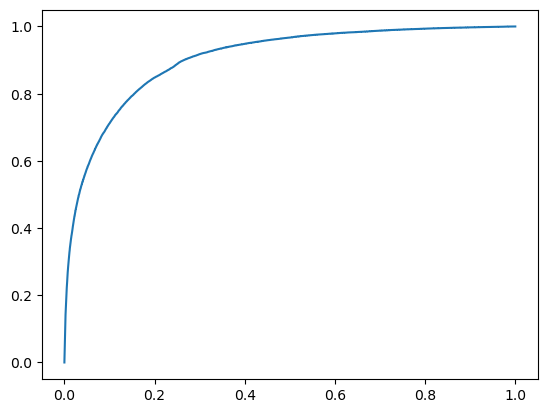

In [17]:
import matplotlib.pyplot as plt
best_auc=0
for step in tqdm(range(1, max_epoch + 1),total=max_epoch,dynamic_ncols=True):
    if step > 1 and config.lr[step - 1] != config.lr[step - 2]:
        for param_group in optimizer.param_groups:
            param_group["lr"] = config.lr[step - 1]

    if (step - 1) % len(train_nloader) == 0:
        loadern_iter = iter(train_nloader)

    if (step - 1) % len(train_aloader) == 0:
        loadera_iter = iter(train_aloader)

    train(loadern_iter, loadera_iter, model,32, optimizer, viz, device)

    #if step % 5 == 0 and step > 0:

    auc,fpr,tpr = test(test_loader, model, viz, device)
    print(auc)
    if auc>best_auc:
        best_auc=auc
        bestfpr=fpr
        besttpr=tpr
    test_info["epoch"].append(step)
    test_info["test_AUC"].append(auc)
        
    if test_info["test_AUC"][-1] > best_AUC:
        best_AUC = test_info["test_AUC"][-1]
        torch.save(model.state_dict(), './ckpt/' +model_name + '{}-i3d.pkl'.format(step))
        save_best_record(test_info, os.path.join(output_path, '{}-step-AUC.txt'.format(step)))
torch.save(model.state_dict(), './ckpt/' + model_name + 'final.pkl')

plt.plot(bestfpr,besttpr)
plt.show()




In [18]:
print(best_auc)

0.9044848429516699


In [19]:
np.save("bestfpr.npy",bestfpr)
np.save("besttpr.npy",besttpr)